# Домашнее задание 3. Детекция объектов

Сыграем в квиддич? Или лучше в карты?

В этом дз вам предстоит написать практически с нуля архитектуру для детекции, а также воспользоваться готовым решением. На выбор даётся два датасета, отличаются они только картинками. Форматы, баллы - все одинаково.

Первый вариант это датасет по кадрам игры в квиддич из Гарри Поттера. Если вы забыли правила, то нажмите [сюда](https://harrypotter.fandom.com/ru/wiki/%D0%9A%D0%B2%D0%B8%D0%B4%D0%B4%D0%B8%D1%87). Вы научитесь искать и выделять на фотографиях бладжеры, квоффл и снитч.

Второй вариант это датасет с игральными картами. Если вы забыли что такое карты, то нажмите [сюда](https://ru.wikipedia.org/wiki/%D0%98%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B0%D1%80%D1%82%D1%8B). Вы научитесь искать и выделять на фотографиях несколько типов карт.

Оба варианта содержат около 300 картинок, данные хранятся в xml в формате PascalVOC. Есть малые отличия, но ничего страшного.


Если с самописным детектором совсем не получается, то можно после создания датасетов перейти к концу, где обучается готовый, с ним будет проще :)

# Notes

Дз проверялось на работоспособность в colab. Не гарантируется, что будет работать на чем-то другом, и точно не будет работать из коробки на Windows.

По вопросам формулировок (не ошибок торча!), в случае отсутствия ответа в общем чате (поиск по чату позволяет проверить), можно написать в него с тегом @markblumenau.

## Данные

Скачайте один из датасетов на свой вкус и начните работу с ним.
Разметка находится в xmls папке, картинки в images.

In [1]:
# Harry Potter -- uncomment
# !wget https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip

# Cards -- uncomment
!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip



!unzip -q data.zip

# Задача 1. 0.5 балла.

Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

In [2]:
import torch
from xml.etree import ElementTree as ET
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
import glob
import numpy as np
from PIL import Image
import torchvision
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm
from torch import nn
import shutil
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

Функции можно и нужно передать некий class_dict. Он есть и при инициализации датасета ниже. С его помощью можно название класса превратить в int. Далее подразумевается, что класс идёт как int.

In [3]:
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_name.split("/")[-1].split(".")[0]
    # read xml
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()
    # iterate over bboxes
    bboxes = []
    for member in treeroot.findall("object"):
        # you need: xmin ymin xmax ymax, class in dict
        res = (
            int(member.find("bndbox")[0].text), 
            int(member.find("bndbox")[1].text), 
            int(member.find("bndbox")[2].text), 
            int(member.find("bndbox")[3].text),
            class_dict[member.find("name").text]
        )

        bboxes.append(res)

    return bboxes

In [4]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"
        
        self.filenames = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}
        
        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):
        ### YOUR CODE HERE ###

        fname = self.filenames[idx]
        image = np.array(Image.open(fname))
        bboxes = get_xml_data(fname, self.root, self.class_dict, xml_prefix="/xmls/")

        return self.transform(image=image, bboxes=bboxes)

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):
        ### YOUR CODE HERE ###

        return len(self.filenames)

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [5]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [6]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

# Задача 2. 1 балл.

Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели. Напишите функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.

В датасете есть class_dict_inv, который позволит вам сделать обратное преобразование: int, содержащий класс, в строку с названием.


Полезные функции:
* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- легко создавать несколько изображений в одной pyplot figure
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- отображение графиков (не забудьте откатить нормализацию)
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- для рисования прямоугольников и текста с аннотацией

In [7]:
def visualize(images, bboxes):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):
        ax.axis(False)

        if i >= len(images):
            break
        # Вот тут нужно выполнить permute (вспомните где у torch каналы, а где они у matplotlib)
        # И откатить нормализацию (просто обратное преобразование)
        # Имена и количества классов можно подтянуть из датасета через train_ds.class_dict_inv
        
        image = images[i]
        image_channels = []
        
        for j in range(image.shape[0]):
            channel_j = image[j] * std[j] + mean[j]
            image_channels.append(channel_j)
        
        unnormalized_image = torch.stack(image_channels)
        
        ax.imshow(unnormalized_image.permute(1, 2, 0))
        
        for bbox in bboxes[i]:
        ### YOUR CODE HERE ###
            xy = (bbox[0], bbox[1])
            width = bbox[2] - bbox[0]
            height = bbox[3] - bbox[1]
            p = plt.Rectangle(xy=xy, 
                              width=width, 
                              height=height, 
                              fill=False, 
                              color='green', 
                              linewidth=2)
            
            ax.add_patch(p)
            ax.text(x=bbox[0], 
                    y=bbox[1] - 10, 
                    s=train_ds.class_dict_inv[bbox[4]], 
                    color='white', 
                    fontsize=12, 
                    backgroundcolor='green')
            
    fig.tight_layout()
    plt.show()

У вас должно получиться что-то похожее на изображения для датасета с масками:

![image](https://gcdnb.pbrd.co/images/n8BnhhfCgYnQ.png)

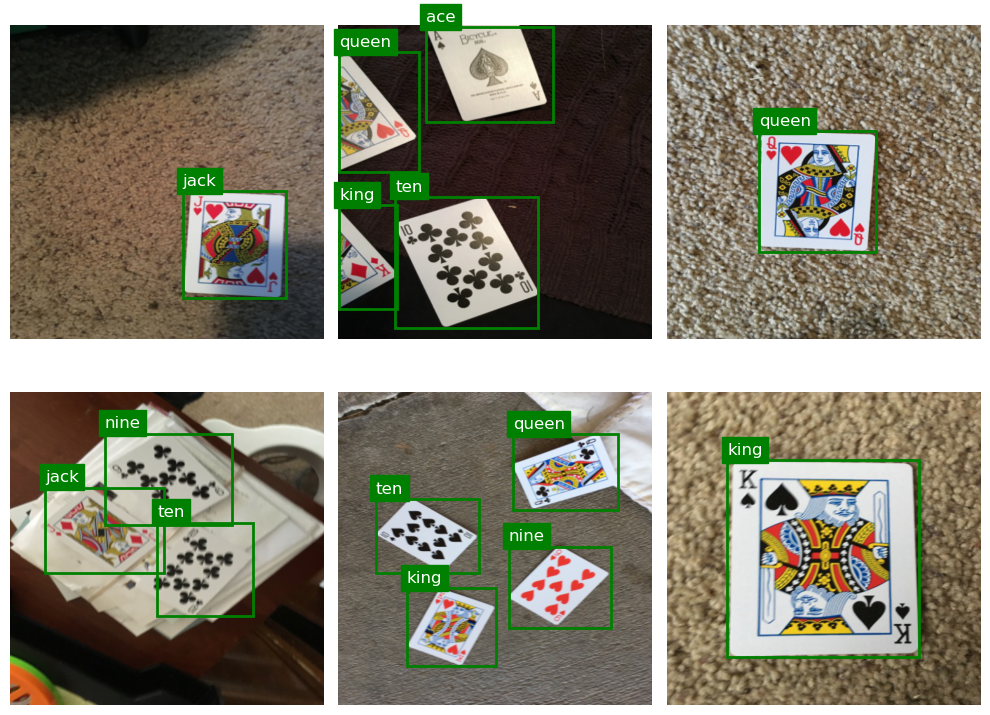

In [8]:
out = [train_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out])

# Задача 3. 3 балла.
## YOLO-like детектор

Сейчас нам предстоить реализовать детектор, похожий на YOLO. Это один из самых простых детекторов с точки зрения реализации. YOLO описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Здесь мы его немного изменим и упростим. Будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16.

We convert lists of bounding boxes to the target downsampled grid. For this we

* compute centers of bounding boxes ($c_x, c_y$)
* change center coordinates (offset from the top left corner for each corresponding grid cell on a small grid)
* normalize box height and with to $[0, 1]$
* fill the target grid with values

## Задача 3.1. 1 балл.

Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров (смотрите [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) для деталей).

Это функция должна принять на вход лист прямоугольников и сгенерировать тензор размера Bx16x16x6. Первая размерность - это количество примеров в батче. Далее идут две пространственные размерности, это сетка 16 на 16. 

В каналах у нас будут записаны:
* Сдвиги центра bbox относительно начала клеточки (клеточка это "пиксель" на изображении 16 на 16 на выходе сети). Записаны эти сдвиги будут в клеточку, к которой относятся. 2 канала (X, Y)
* Нормализованные ширина и высота bbox. 2 канала (W, H)
* Confidence сетки. Им мы будем пользоваться, чтобы фильтровать уверенность сетки в наличии bbox в данной клетке. Таргет содержит 1 там, где bbox есть, и 0 иначе. 1 канал
* Класс детекции (тот самый int, полученный из строки с названием)

In [9]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))

    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes):
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )

        # Нормализуйте ширину и высоту, поделив на ширину и высоту исходного изображения
        x_cell = downsample # TODO размер клетки по X в пикс
        y_cell = downsample # TODO размер клетки по Y в пикс
        w_box = (xmax - xmin) / w # TODO ширина бокса отнормированная
        h_box = (ymax - ymin) / h # TODO высота бокса отнормированная

        # Посчитайте координаты центра и сдвиги
        cx = (xmax + xmin) / 2 # TODO (координаты центра в исходных координатах)
        cy = (ymax + ymin) / 2 # TODO

        cx_idx = (cx // downsample).long() # TODO (посчитайте индекс центра на карте признаков размера 16x16. Это будут как раз координаты пикселя, куда мы запишем параметры коробки)
        cy_idx = (cy // downsample).long() # TODO

        cx_box = (cx - cx_idx * downsample) / downsample # TODO (посчитайте сдивиги относительно cx_idx)
        cy_box = (cy - cy_idx * downsample) / downsample # TODO

        target[i, :, cy_idx, cx_idx] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
        )

    return {"image": imgs, "target": target}

Ниже вы можете увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

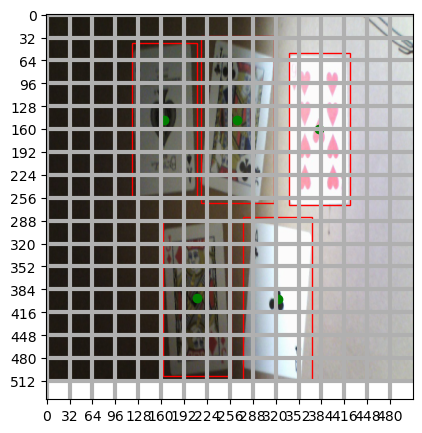

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()

## Задача 3.2. 0.5 балла.

Выход нашей сетки будет несколько больше, чем Bx16x16x6. Почему? 

Мы решаем задачу, где классов больше одного. Вспомним прошлое дз: target был одним числом, но выход сетки содержал длинный-длинный вектор, из которого мы получали вероятность принадлежности к тому или иному классу. Здесь то же самое, но как бы в двумерии: у каждой клеточки из этих 16*16 будет свой вектор длины C, который мы будем использовать для определения класса.

Реализуйте обратное относительно collate_fn преобразования, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function вы должны получить изначальный набор прямоугольников с корректными размерами и координатами, а также классами. Применив к выходу нейросети мы тоже должны получить набор прямоугольников и тоже с корректными классами. 

То есть, нужно проделать операции из collate_fn в обратную сторону, но учесть, что у неройнки выход будет чуть длиннее, и там мы должны брать argmax для определения класса.

Hint: в target classes идут в конце. В нейронке они тоже будут в конце, но их будет больше 1. Можно проверять число каналов пришедшего объекта, если оно 6, то перед нами target и надо брать значение, которое записано в клеточке. Иначе (каналов больше 6) перед нами выход нейронки, и надо брать самый вероятный из них.

In [11]:
def decode_prediction(pred, upsample=32, threshold=0.7):
    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample
    ### YOUR CODE HERE ###
    decoded_prediction = [0 for i in range(b)]
    
    for i in range(b):
        has_bbox = torch.where(pred[i, 4, :, :] > threshold, pred[i, 4, :, :], torch.zeros_like(pred[i, 4, :, :]))
        cx_idx = has_bbox.nonzero(as_tuple=True)[1]
        cy_idx = has_bbox.nonzero(as_tuple=True)[0]
        cx_box = pred[i, 0, cy_idx, cx_idx]
        cy_box = pred[i, 1, cy_idx, cx_idx]
        w_box = pred[i, 2, cy_idx, cx_idx]
        h_box = pred[i, 3, cy_idx, cx_idx]

        cx = cx_box * upsample + cx_idx * upsample
        cy = cy_box * upsample + cy_idx * upsample

        xmax_plus_xmin = cx * 2
        ymax_plus_ymin = cy * 2
        xmax_minus_xmin = w_box * img_w
        ymax_minus_ymin = h_box * img_h

        # solve system on piece of paper ...
        xmaxs = (xmax_plus_xmin - xmax_minus_xmin) / 2 + xmax_minus_xmin
        xmins = (xmax_plus_xmin - xmax_minus_xmin) / 2
        ymaxs = (ymax_plus_ymin - ymax_minus_ymin) / 2 + ymax_minus_ymin
        ymins = (ymax_plus_ymin - ymax_minus_ymin) / 2
            
        if c == 6: # target object
            classes = pred[i, 5, cy_idx, cx_idx]
        elif c > 6: # nn output
            classes = torch.argmax(pred[i, 5:, cy_idx, cx_idx], dim=0)
        else: # unknown 
            raise 'It is not target or model output object'
        
        decoded_prediction[i] = (
                [(float(xmin), float(ymin), float(xmax), float(ymax), int(class_)) for xmin, ymin, xmax, ymax, class_ in zip(xmins, ymins, xmaxs, ymaxs, classes)]
            )

    return decoded_prediction

## Задача 3.3. 1 балл.
Реализуйте модель. Первым делом примените первые 4 блока (до layer4 включительно) ResNet50. Далее добавьте несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно уменьшайте количество каналов до 5+C, а размер изображения до 16 на 16. Например, 2048 -> 512 -> 128 -> 32 -> 5+C, где С - количество классов в вашем датасете. Размер ядра при этом 3, паддинг 1. Но вариантов много, попробуйте разные! **Последним слоем обязательно должна быть свертка.** Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не навредит.

Если будете фантазировать, то для получения правильного размера изображения после сети не стесняйтесь применять слои с фильтрами больше 3.

Далее добавьте несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно уменьшайте количество каналов до 5+C, а размер изображения до 16 на 16. Например, 2048 -> 512 -> 128 -> 32 -> 5+C, где С - количество классов в вашем датасете. Размер ядра при этом 3, паддинг 1. Но вариантов много, попробуйте разные! Последним слоем обязательно должна быть свертка. Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не навредит.

In [12]:
C = 6 # Количество классов в вашем датасете, хоть руками посчитайте, хоть подтяните из словаря классов


class Detector(nn.Module):
    def __init__(self):
        super().__init__()
        model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        ### YOUR CODE HERE ###
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        self.conv = model.conv1
        self.bn = model.bn1
        self.maxpool = model.maxpool
        self.layer1 = model.layer1
        self.layer2 = model.layer2
        self.layer3 = model.layer3
        self.layer4 = model.layer4
        
        self.conv1 = nn.Conv2d(in_channels=2048, out_channels=512, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(512)
        
        self.conv2 = nn.Conv2d(in_channels=512, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=5+C, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(5+C)
        
    def forward(self, img):
        ### YOUR CODE HERE ###
        with torch.no_grad():
            x = self.conv(img)
            x = self.bn(x)
            x = self.relu(x)
            x = self.maxpool(x)
            
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)

        x = self.conv1(x)

        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)

        x = self.sigmoid(x)
        
        return x

## Задача 3.4. 0.5 балла.

Реализуйте функцию потерь.

Для этого:
* Сделайте маску, которая будет говорить о положении детектируемых объектов. Её нужно использовать с помощью masked_select (см. доки PyTorch)
* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)
    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект
    - box_loss - MSE от корней ширины и высоты bbox там, где есть детектируемый объект
    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу
    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше, но можно экспериментировать)


* Ниже есть assert. Если вы экспериментируете с лоссом, он не будет проходить, не обращайте на него внимание. Если будете делать описанное выше, то учтите reduction. Бинарная кросс-энтропия вызывается через BCELoss. Параметр C используется для задачи числа классов. assert написан для 3 классов, в задаче с картами их 6. Подумайте как зависит индексация от параметра C и используйте его.

In [84]:
def special_loss(pred, target, check=False, C=C):
    ### YOUR CODE HERE ###
    target = target[:, :6, :, :]
    mask = (target[:, 4, :, :] == 1)

    localization_loss = nn.MSELoss(reduction='sum')(
        torch.masked_select(target[:, 0, :, :], mask), torch.masked_select(pred[:, 0, :, :], mask)
    ) + nn.MSELoss(reduction='sum')(
        torch.masked_select(target[:, 1, :, :], mask), torch.masked_select(pred[:, 1, :, :], mask)
    )
    
    box_loss = nn.MSELoss(reduction='sum')(
        torch.sqrt(torch.masked_select(target[:, 2, :, :], mask)), torch.sqrt(torch.masked_select(pred[:, 2, :, :], mask))
    ) + nn.MSELoss(reduction='sum')(
        torch.sqrt(torch.masked_select(target[:, 3, :, :], mask)), torch.sqrt(torch.masked_select(pred[:, 3, :, :], mask))
    )

    mod_pred = torch.zeros_like(target)

    for i in range(target.shape[0]):
        for j in range(target.shape[2]):
            for k in range(target.shape[3]):
                class_ = target[i, 5, j, k].long()

                mod_pred[i, :, j, k] = torch.stack(
                    [pred[i, 0, j, k], 
                     pred[i, 1, j, k], 
                     pred[i, 2, j, k], 
                     pred[i, 3, j, k], 
                     pred[i, 4, j, k], 
                     pred[i, 5+class_, j, k]]
                )      

    classification_loss = nn.CrossEntropyLoss(reduction='sum')(
        torch.masked_select(mod_pred[:, 5, :, :], mask), 
        torch.masked_select(target[:, 5, :, :], mask)
    )
        
    weigths = target[:, 4, :, :]
    weigths[weigths == 0] = 0.1
    confidence_loss = nn.BCELoss(weight=weigths, reduction='sum')(
        pred[:, 4, :, :], target[:, 4, :, :]
    )
    
    if not check:
        return localization_loss + box_loss + classification_loss + confidence_loss

    else:
        return localization_loss, box_loss, classification_loss, confidence_loss

In [85]:
# localization box classification confidence - возвращаются в таком порядке, можно сравнить
assert special_loss(torch.zeros((10, 8, 16, 16)), torch.ones((10, 8, 16, 16)), check=True, C=6) == (torch.tensor(5120.), torch.tensor(5120.), torch.tensor(2812.4465), torch.tensor(256000.))

AssertionError: 

# Задача 4. 2 балла.

Обучите вашу модель (написав цикл обучения), и покажите что она работает (скорее всего, объекты найдутся на 1-2 картинках).

In [86]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)

In [87]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(21)
EPOCHS = 15 # Harry Potter 20, Cards 15
model = Detector().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    for batch in pbar:
        ### YOUR CODE HERE ###
        target = batch['target']
        
        pred = model(batch['image'])
        
        loss = special_loss(pred, target)
        loss.backward()
        
        opt.step()
        opt.zero_grad()

        epoch_losses.append(float(loss))


    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 0 done; Train loss 325.861;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1 done; Train loss 310.899;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2 done; Train loss 305.145;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3 done; Train loss 302.699;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4 done; Train loss 301.872;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5 done; Train loss 301.609;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6 done; Train loss 301.430;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7 done; Train loss 301.332;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 8 done; Train loss 301.247;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9 done; Train loss 301.240;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10 done; Train loss 301.178;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 11 done; Train loss 301.171;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 12 done; Train loss 301.109;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 13 done; Train loss 301.103;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 14 done; Train loss 301.122;


Запустим обученный детектор на тестовых изображениях:

In [88]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [89]:
# Нужно сделать предсказание и переложить результат на cpu

### YOUR CODE HERE ###
preds = []
pbar = tqdm(test_loader, leave=False)
for batch in pbar:
    target = batch['target']
        
    pred = model(batch['image']).to("cpu")

    preds.append(pred)
      

  0%|          | 0/7 [00:00<?, ?it/s]

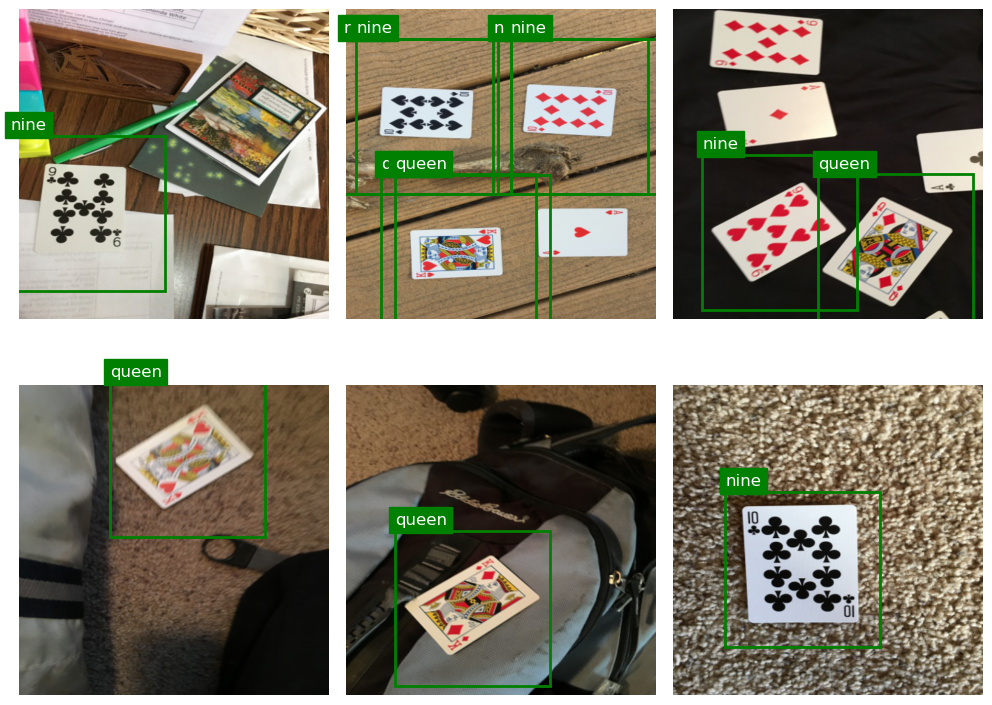

In [99]:
# Сделайте визуализацию. Поиграйтесь с threshold, скорее всего нужно понизить до ~0.1

### YOUR CODE HERE ###
out = [test_ds[i] for i in range(6)]
visualize([o["image"] for o in out], decode_prediction(preds[0], threshold=0.95))

Результат сильно так себе, да? Есть множество вариантов улучшений, самый простой из которых это приделать к выходу [NMS](https://paperswithcode.com/method/non-maximum-suppression#:~:text=Non%20Maximum%20Suppression%20is%20a,below%20a%20given%20probability%20bound.). Если хочется, можно почитать про YOLO v1 [тут](https://arxiv.org/abs/1506.02640).

# Задача 5. 3.5 балла.

Займёмся более простыми вещами. Возьмем готовую архитектуру, обучим её на наших данных и посмотрим.

Для этого будем использовать YOLO v8 от ultralytics.

In [100]:
# !pip install ultralytics

## Задача 5.1. 1.5 балла.

Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Да-да, классика перекладывания JSON. Как правильно паковать можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).

Если коротко:
* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия
* Есть папочки train valid (их поможем вам собрать), в них две подпапки:
    - Первая images, в ней лежат картинки
    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [80]:
# Делаем папочки
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

Реализуйте функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO v8. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.

In [82]:
def annotation2txt(bboxes, w_im, h_im):
    ### YOUR CODE HERE ###
    data = []
    
    for bbox in bboxes:
        class_id = bbox[4]
        center_x = (bbox[2] + bbox[0]) / 2 / w_im
        center_y = (bbox[3] + bbox[1]) / 2 / h_im
        width = (bbox[2] - bbox[0]) / w_im
        height = (bbox[3] - bbox[1]) / h_im
    
        data.append(f'{class_id} {center_x} {center_y} {width} {height}')
    
    return data

In [83]:
# Копируем картиночки по папочкам и создаем txt файлики

for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )

    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [84]:
# Собираем YAML

nc = 6 # Укажите число классов. Хоть руками, хоть по-умному посчитайте (см. class_dict)
names = ["king", "jack", "ace", "ten", "nine", "queen"] # Укажите имена классов. Хоть руками, хоть по-умному посчитайте, это массив строк (см. class_dict)

with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")

## Задание 5.2. 1.5 балла.

Обучите модель YOLO v8 самого маленького размера. Библиотека максимально friendly, от вас требуется написать две строчки. Модель нужно взять необученную!

Подсказка: подумайте зачем вам data.yaml и что такое yolov8n.yaml (не стесняйтесь гуглить)

In [85]:
import ultralytics

### YOUR CODE HERE ###
model = ultralytics.YOLO('yolov8n.yaml')

results = model.train(data='data.yaml', epochs=100, device='mps')


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

wandb: Currently logged in as: alekseyshabunya (aleksey_shabunya). Use `wandb login --relogin` to force relogin


Freezing layer 'model.22.dfl.conv.weight'


train: Scanning /Users/alex/Documents/iad-deep-learning/2023/homeworks/hw3/train

train: New cache created: /Users/alex/Documents/iad-deep-learning/2023/homeworks/hw3/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /Users/alex/Documents/iad-deep-learning/2023/homeworks/hw3/valid/l

val: WARNING ⚠️ /Users/alex/Documents/iad-deep-learning/2023/homeworks/hw3/valid/images/cam_image12.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.2196]
val: WARNING ⚠️ /Users/alex/Documents/iad-deep-learning/2023/homeworks/hw3/valid/images/cam_image36.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.5357       1.537]
val: WARNING ⚠️ /Users/alex/Documents/iad-deep-learning/2023/homeworks/hw3/valid/images/cam_image38.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.7209      1.1534       1.713      1.1389]
val: New cache created: /Users/alex/Documents/iad-deep-learning/2023/homeworks/hw3/valid/labels.cache
Plotting labels to runs/detect/train7/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train7
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      3.045      4.812       4.43         26        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34         65   0.000602      0.123   0.000506   0.000127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      2.922      4.432      4.085         21        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34         65   0.000954      0.198    0.00179   0.000289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      2.845      4.003      3.751         21        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34         65    0.00129        0.2     0.0024   0.000513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      2.749      3.781      3.482         16        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34         65    0.00124      0.184    0.00194   0.000399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      2.583      3.595      3.196         26        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34         65    0.00377      0.129    0.00338   0.000716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      2.468      3.569      3.054         25        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34         65    0.00363     0.0951     0.0033   0.000823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G      2.278      3.383      2.883         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34         65      0.279     0.0337     0.0384     0.0161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G      2.093      3.162      2.697         25        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34         65      0.427     0.0684     0.0396     0.0213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G      1.977      3.121      2.553         20        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34         65      0.418     0.0622     0.0455     0.0279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G      1.799      2.998      2.325         22        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.134     0.0464     0.0483     0.0254

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G      1.726       2.89      2.257         23        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34         65      0.464     0.0473     0.0442     0.0223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G      1.578      2.833      2.111         37        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.388     0.0488     0.0531      0.032

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G      1.577      2.722      2.047         21        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.349     0.0627     0.0557     0.0295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G      1.462      2.638      1.939         19        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.444     0.0807     0.0588     0.0319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G      1.454      2.553      1.858         26        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65       0.47     0.0835     0.0663      0.043

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G       1.39      2.549      1.843         20        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65       0.31     0.0835     0.0657     0.0443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G      1.349      2.516      1.788         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.405     0.0835     0.0657     0.0448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G      1.307      2.433      1.731         21        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.289     0.0797     0.0669     0.0495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G      1.275       2.43      1.693         19        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34         65      0.711     0.0545     0.0646     0.0404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G      1.243      2.365      1.653         19        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65       0.43     0.0835     0.0716     0.0539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G      1.227      2.345      1.611         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.284     0.0835     0.0799     0.0598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G      1.227      2.325      1.597         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.525      0.028     0.0309     0.0247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G      1.197      2.233      1.572         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65       0.21      0.028     0.0317     0.0288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G      1.178      2.253      1.549         25        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34         65      0.466     0.0835     0.0776     0.0536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G      1.157      2.283      1.536         35        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.391      0.028     0.0328     0.0276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G      1.133      2.232      1.497         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.579     0.0128     0.0331     0.0284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G      1.122      2.218       1.46         19        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.345      0.028     0.0316     0.0239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G      1.168      2.236      1.498         24        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.469     0.0835     0.0741     0.0591

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G      1.128        2.2      1.474         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.425      0.028     0.0315     0.0256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G      1.046      2.123      1.405         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.568      0.028      0.031     0.0265

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G      1.069      2.139      1.426         18        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.534      0.028     0.0311      0.028

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G      1.071      2.157      1.412         18        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.414      0.028      0.031     0.0262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G      1.066      2.162      1.428         25        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.406      0.028      0.031     0.0279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G      1.056      2.161      1.394         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.482     0.0835     0.0795     0.0574

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G      1.042       2.16      1.393         19        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.185      0.028      0.031     0.0283

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G      1.047      2.145      1.383         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.422      0.028     0.0329      0.031

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G      1.063      2.143      1.418         18        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.421      0.028     0.0322     0.0276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G      0.987      2.091      1.352         22        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.412     0.0835     0.0715     0.0521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G      1.004      2.058      1.342         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.384      0.028      0.031     0.0279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G     0.9939      2.079      1.326         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.433     0.0835     0.0812     0.0607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G      1.028      2.088      1.371         20        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.419      0.028     0.0316     0.0253

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G     0.9651      2.053      1.334         19        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.509     0.0696     0.0813     0.0684

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G      0.953       2.06      1.315         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.937      0.028     0.0312     0.0281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G      0.957       2.04      1.294         21        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.414      0.028     0.0321     0.0256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G      0.928      2.004      1.282         15        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.405      0.028     0.0313     0.0281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G      0.941      1.992      1.277         21        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.403      0.028      0.031     0.0279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G     0.9183      1.999      1.277         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.404      0.028     0.0315      0.027

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G     0.9216      2.003      1.283         16        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.572      0.028     0.0312     0.0299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G     0.8796      1.944      1.243         24        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.762      0.028     0.0312      0.025

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G     0.9035      1.961      1.269         24        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.922      0.028     0.0314       0.03

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G     0.8868      2.013       1.27         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.391      0.028     0.0328     0.0313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G     0.8548      1.969      1.236         20        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.395      0.028     0.0317     0.0285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G     0.8703      1.923      1.242         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.388      0.028     0.0354     0.0316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G     0.8382      1.916      1.229         25        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.455     0.0835     0.0884     0.0677

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         0G     0.8478      1.918      1.226         22        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.397      0.028     0.0329     0.0281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100         0G     0.8508      1.929      1.223         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.524     0.0835     0.0894     0.0665

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100         0G     0.8627      1.921      1.234         25        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.411      0.028     0.0348     0.0313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100         0G     0.8354      1.906      1.222         22        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.922      0.028     0.0337     0.0285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100         0G     0.8276      1.904      1.197         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.894      0.028     0.0321     0.0292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100         0G     0.8114      1.885      1.187         22        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.435     0.0794     0.0803      0.066

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100         0G     0.8146      1.903      1.192         36        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.738      0.028      0.038     0.0323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100         0G     0.8179      1.873      1.203         16        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.443     0.0835     0.0884     0.0727

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100         0G     0.8609      1.915      1.225         22        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.548      0.083     0.0815     0.0635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100         0G     0.8678      1.928      1.235         16        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.386      0.028     0.0325     0.0293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100         0G     0.7989      1.837      1.193         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.521     0.0835     0.0896     0.0701

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100         0G     0.8258      1.861      1.202         24        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65       0.52     0.0835     0.0904     0.0772

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100         0G     0.8297      1.886      1.207          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.747      0.028     0.0337     0.0285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100         0G     0.7957      1.863      1.178         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.372      0.028     0.0319     0.0301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100         0G     0.8232      1.913      1.209         21        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65       0.43     0.0835     0.0799     0.0613

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100         0G      0.811      1.933      1.198         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.574      0.028     0.0324     0.0292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100         0G     0.8004      1.837      1.182         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.465     0.0835      0.091      0.073

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100         0G     0.8049      1.843       1.18         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.928      0.028     0.0312     0.0295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100         0G     0.8143      1.846      1.182         17        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.912      0.028     0.0312      0.028

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100         0G     0.7821      1.838      1.165         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.918      0.028     0.0344     0.0329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100         0G     0.7795       1.83      1.173         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.954      0.028     0.0373     0.0336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100         0G     0.7641      1.789      1.161         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.927      0.028     0.0367      0.033

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100         0G     0.7794      1.846      1.174         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.939      0.028     0.0318     0.0286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100         0G     0.7348      1.778      1.161         16        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.959      0.028     0.0313     0.0282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100         0G     0.7382      1.775      1.136         24        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.935      0.028     0.0322     0.0308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100         0G     0.7476      1.786      1.158         22        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.927      0.028     0.0418     0.0376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100         0G     0.7543      1.773      1.152         26        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.936      0.028     0.0384     0.0346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100         0G      0.744      1.785      1.146         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.736      0.028     0.0358     0.0322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100         0G     0.7346      1.759      1.146         26        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.521     0.0835     0.0924     0.0746

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100         0G     0.7324      1.753      1.129         16        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.975      0.028     0.0366     0.0366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100         0G     0.7225      1.745      1.144         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.566     0.0812      0.097     0.0807

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100         0G     0.7585      1.811      1.167         21        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.942      0.028     0.0728     0.0694

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100         0G     0.7635      1.806      1.159         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.524     0.0835     0.0979     0.0807

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100         0G      0.749      1.766      1.161         21        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.546     0.0835     0.0961     0.0794

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100         0G     0.7506      1.773      1.156         21        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.969      0.028     0.0376     0.0338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100         0G     0.7317      1.747      1.146         25        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.566     0.0835     0.0941     0.0721
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100         0G     0.7012      1.936      1.107         15        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.918      0.028     0.0371     0.0355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100         0G     0.6493      1.831       1.06         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.376     0.0835      0.085     0.0705

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100         0G     0.6562      1.793       1.06          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65       0.93      0.028     0.0648     0.0583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100         0G     0.6352      1.704      1.043         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.791     0.0408     0.0824     0.0709

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100         0G     0.6335      1.727      1.052          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.802      0.028     0.0648     0.0648

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100         0G     0.6339      1.675      1.064         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.939     0.0408     0.0982      0.095

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100         0G     0.6122      1.695      1.052         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.587     0.0835      0.109     0.0917

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100         0G     0.6124      1.651      1.084         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65       0.54     0.0835      0.112     0.0912

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100         0G     0.6241      1.644      1.084          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65      0.787      0.028     0.0691     0.0653

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100         0G     0.5865      1.687      1.034         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 0.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m

                   all         34         65      0.797      0.028     0.0664     0.0598



100 epochs completed in 2.248 hours.
Optimizer stripped from runs/detect/train7/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train7/weights/best.pt, 6.2MB

Validating runs/detect/train7/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.11.5 torch-2.1.0.post100 MPS (Apple M1 Pro)
YOLOv8n summary (fused): 168 layers, 3006818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  m

WARNING ⚠️ NMS time limit 2.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         34         65        0.5     0.0963      0.133      0.115
                  king         34         13       0.38     0.0769      0.102      0.102
                  jack         34          8      0.957       0.25      0.299      0.255
                   ace         34         13      0.561     0.0769      0.141      0.127
                   ten         34         11      0.367     0.0909       0.13       0.13
                  nine         34         12      0.737     0.0833      0.123     0.0734
                 queen         34          8          0          0          0          0
Speed: 23.7ms preprocess, 430.9ms inference, 0.0ms loss, 132.2ms postprocess per image
Results saved to runs/detect/train7


## Задание 5.3. 0.5 балла.

Как-нибудь отрисуйте предсказания на валидационной выборке (хотя бы части из 5-10 картинок).

Здесь можно использовать костыли с параметром save=True у predict, потом прочитать их чем-нибудь, отрисовать матплотлибом. Есть варианты и получше. Дефолтный show будет пытаться показывать через opencv imshow, он в коллабе работать не будет.

In [171]:
results = model(test_ds.filenames[0:36:6], conf=0.1, imgsz=(512, 384))


WARNING ⚠️ NMS time limit 0.800s exceeded
0: 512x384 1 jack, 1 nine, 1: 512x384 1 king, 2: 512x384 1 ten, 3: 512x384 2 aces, 1 ten, 2 queens, 4: 512x384 1 ace, 5: 512x384 (no detections), 75.0ms
Speed: 4.7ms preprocess, 12.5ms inference, 446.5ms postprocess per image at shape (1, 3, 512, 384)


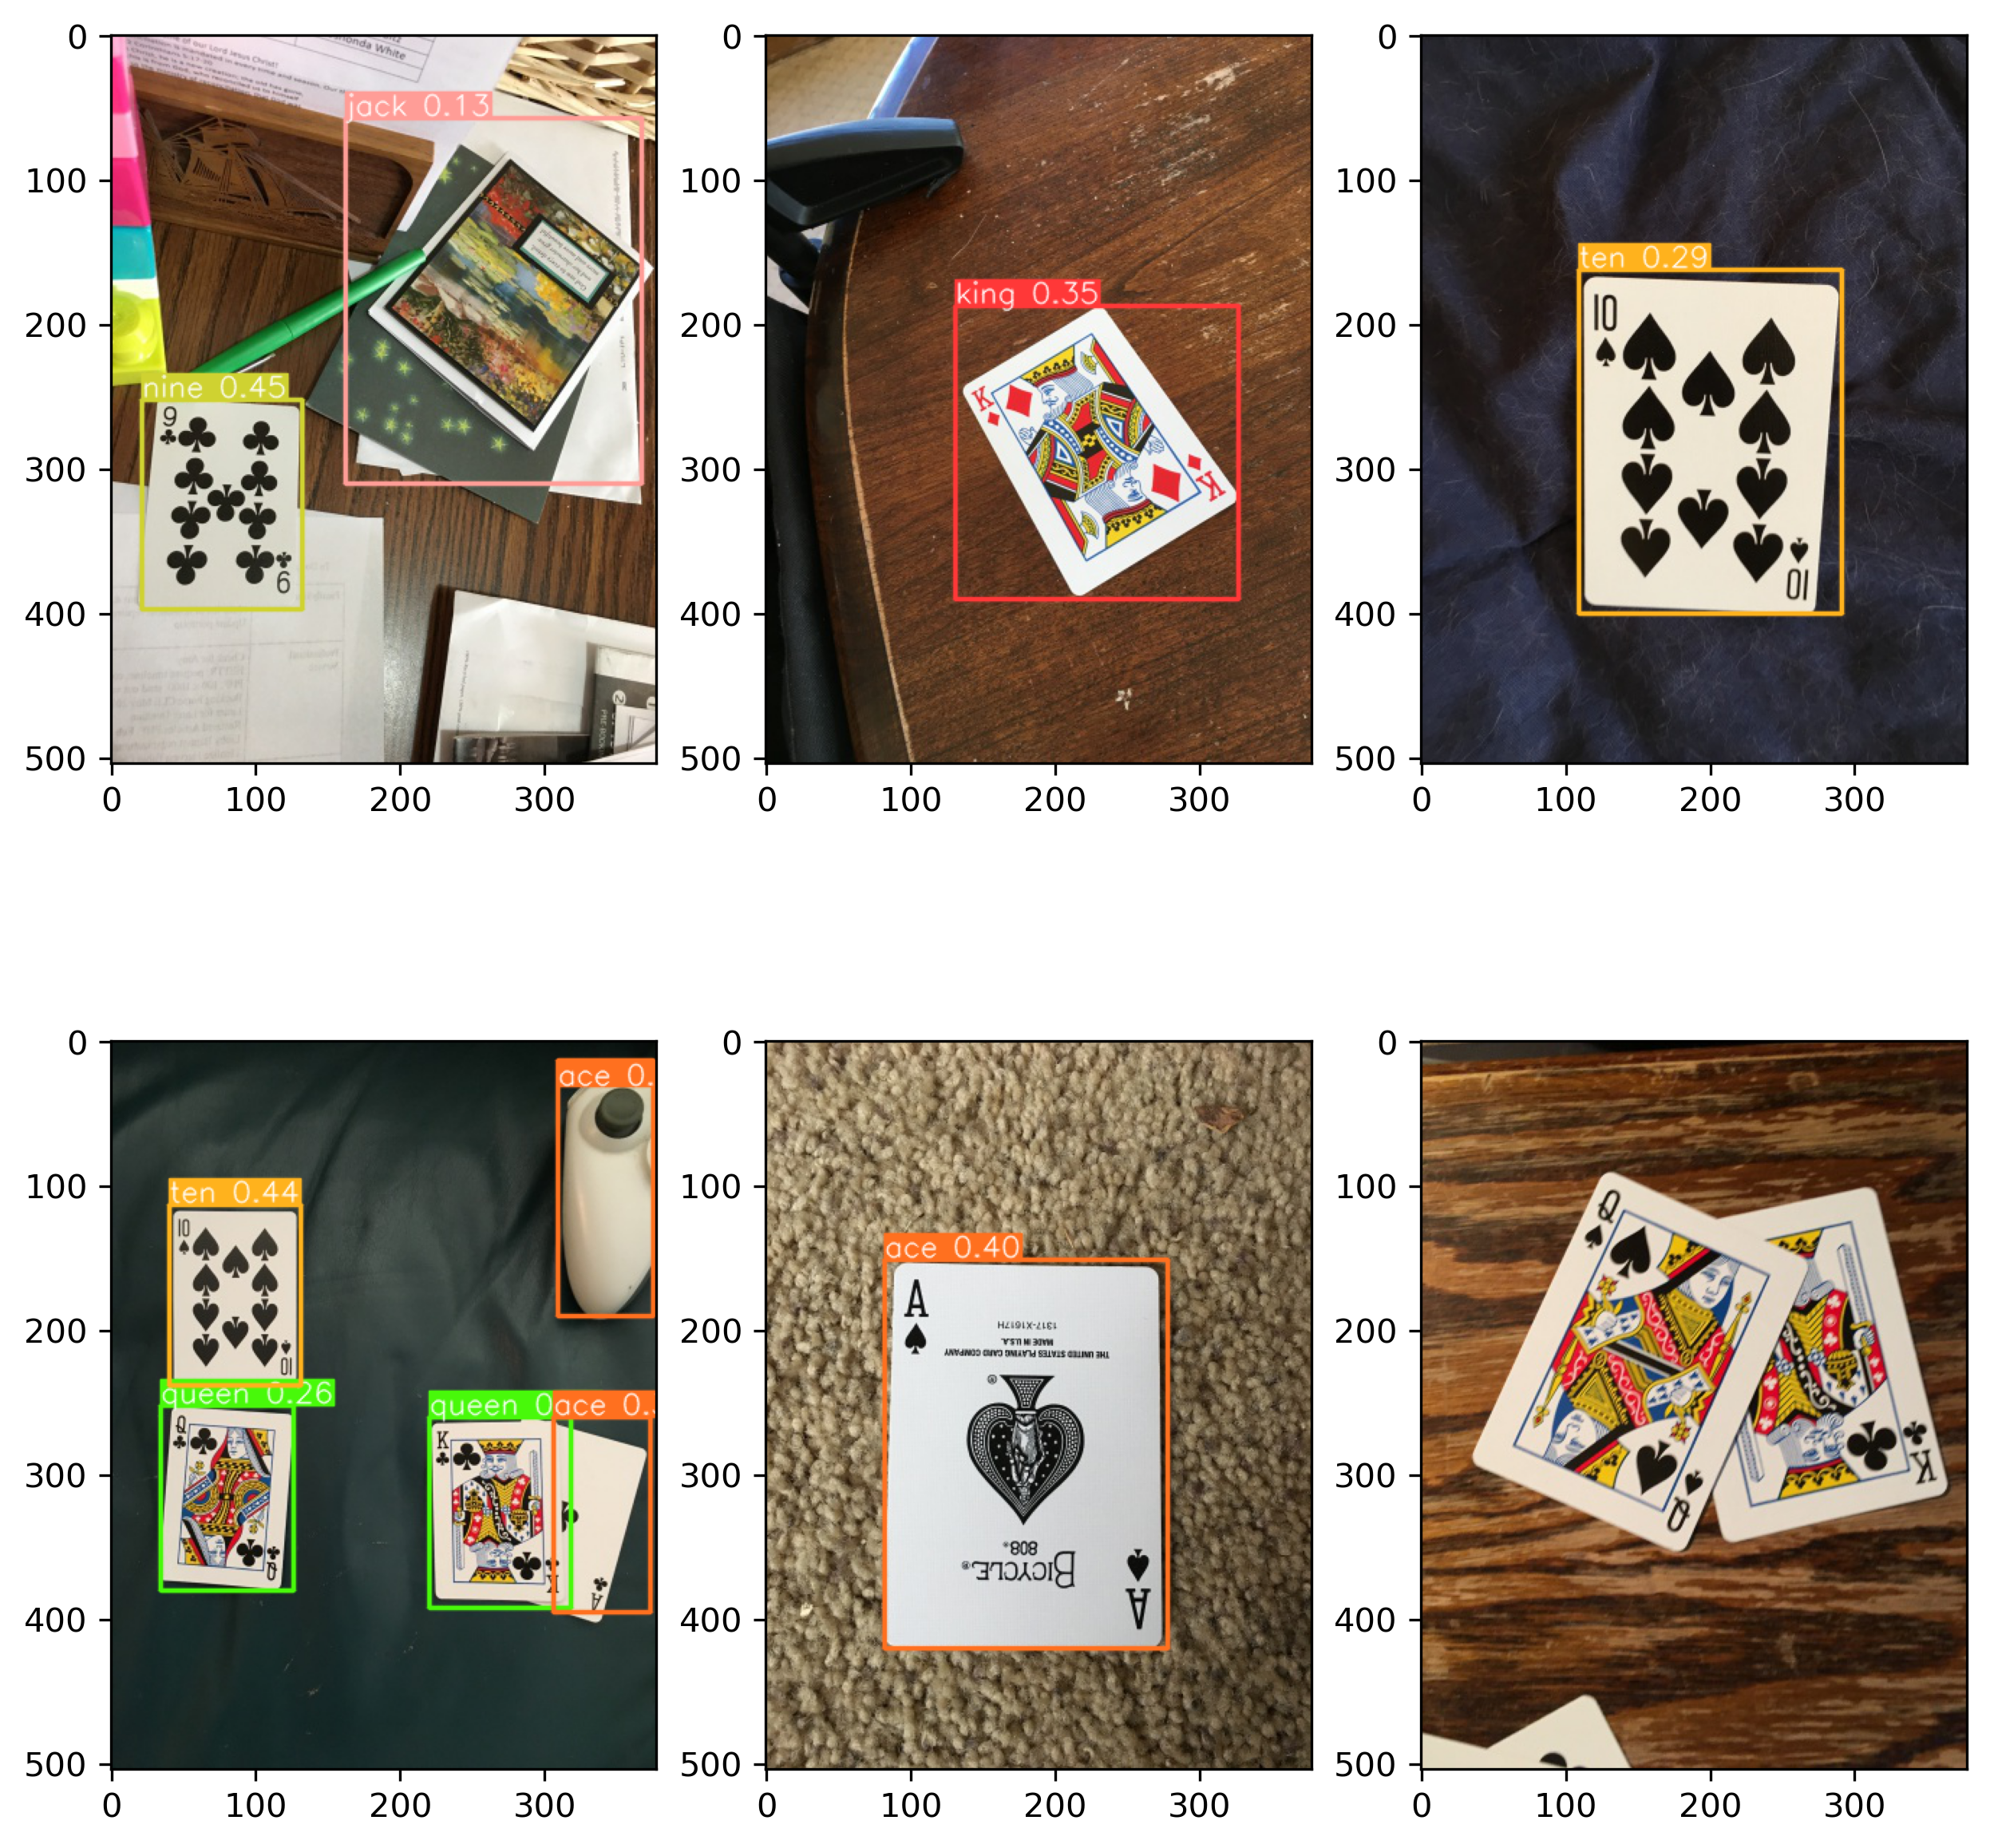

In [172]:
fig, axes = plt.subplots(2, 3, figsize=(10, 10), dpi=300)

for i, r in enumerate(results):
    im_array = r.plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    axes[i // 3][i % 3].imshow(im)  # show image